# FFF on 2d data

In [ ]:
#|hide
import math
import torch
import FastFF.fff as fff
import torchvision.transforms as T
import matplotlib.colors as mcolors
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch import tensor
from matplotlib.lines import Line2D
from fastai.vision.all import *

Points on the boundary plane have to satisfy 

$\displaystyle \sigma(x\cdot w+b)=0.5\Rightarrow x\cdot w+b=0$ 

In [ ]:
def draw_line(w,b,figsize=(5,3), ax = None, **kwargs):
    '''draw boundary line for σ(x@w.T+b). w must have shape 2, b must have shape 1'''
    w1, w2 = w[0], w[1]
    x1 = np.array([-10.0,10.0])
    x2 = (b - w1*x1)/w2
    if not ax: ax = subplots(figsize=figsize)[1][0]
    ax.add_line(Line2D(x1,x2, **kwargs))
    ax.plot()

Draw line from its coefficients

In [ ]:
model = fff.FFF(2, 3, 10, 3)

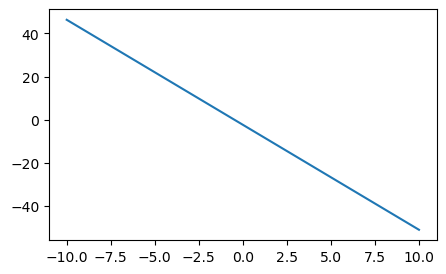

In [ ]:
draw_line(to_np(model.node_weights[0]),to_np(model.node_biases[0]))

In [ ]:
ws, bs = model.node_weights.detach(), model.node_biases.detach()

In [ ]:
print('weights:',ws[0],'\nbias:', bs[0])

weights: tensor([-0.6577, -0.1350]) 
bias: tensor([0.3229])


Let's see what are the lines for the first 2 nodes

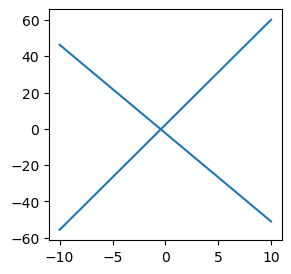

In [ ]:
ax = subplots()[1][0]
draw_line(ws[0],bs[0],ax=ax)
draw_line(ws[1],bs[1],ax=ax)

In [ ]:
def draw_lines(ws,bs, figsize=(6,4), ax=None,**kwargs):
    if not ax: ax = subplots(figsize=figsize)[1][0]
    for i in zip(ws,bs): draw_line(*i,figsize, ax,**kwargs)

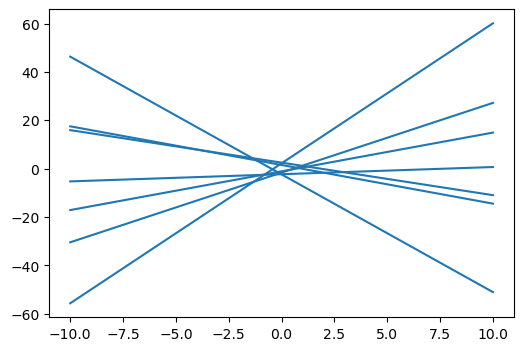

In [ ]:
draw_lines(ws, bs)

## Try to draw with linspaces

In [ ]:
def draw_line(x,y, ax = None, figsize=(5,3), **kwargs):
    if not ax: ax = subplots(figsize=figsize)[1][0]
    ax.add_line(Line2D(x,y, **kwargs))
    ax.plot()

In [ ]:
def get_xy(ws,bs, x1=torch.linspace(-10,10,100)):
    '''returns space of solutions to w1*x1+w2*x2+b=0 for each node. w1,w2 are projections of ws on first 2 dims'''
    w1, w2 = ws[:,0],ws[:,1]                        # (n_nodes,)
    x2 = (-bs - w1[...,None]*x1[None])/w2[...,None] # (n_nodes, 100)
    return x1,x2

In [ ]:
x1, x2 = get_xy(ws,bs)
x1.shape, x2.shape

(torch.Size([100]), torch.Size([7, 100]))

To get mask for some node we have to get its turns (decisions) and intermediate nodes to get to this one

In [ ]:
def idx_to_tree_path(index):
    turns = L(*bin(index+1)[3:]).map(int)
    nodes = reduce(lambda l,idx: l+[l[-1]*2+2 if idx else l[-1]*2+1],turns, [0])
    return turns, nodes

For example
```txt
        0       to get to node 4,  
       / \      we have to visit nodes 0,1 and 4.
      1   2     And turns are [left, right] or [0,1]
     / \ / \
    3  4 5  6
```

In [ ]:
idx_to_tree_path(4)

((#2) [0,1], [0, 1, 4])

In [ ]:
def get_mask(x1,x2, idx, ws,bs):
    '''Get only points that end up in leaf at `idx`'''
    xb = torch.stack([x1, x2[idx]],dim=1)
    mask = torch.ones(xb.shape[0]).bool()
    ts, vs = idx_to_tree_path(idx)
    for t,v in zip(ts,vs[:-1]):
        m = (xb@ws[v,:2]+bs[v]>0)
        if not t: m = ~m
        mask = mask & m
    return mask

In [ ]:
def draw_tree_lines(ws,bs, lin_x = torch.linspace(-10,10,100), ax=None, figsize=(6,4), cmap = 'plasma', **kwargs):
    if not ax: ax = subplots(figsize=figsize)[1][0]
    x1,x2 = get_xy(ws,bs,lin_x) # (100,) (n_nodes,100)
    norm = mcolors.Normalize(vmin=0, vmax=x2.shape[0])
    cmap = plt.get_cmap(cmap)
    for i,col in enumerate(cmap(norm(range(x2.shape[0])))):
        mask = get_mask(x1,x2,i,ws,bs)
        draw_line(x1[mask],x2[i][mask], ax, color=col,**kwargs)

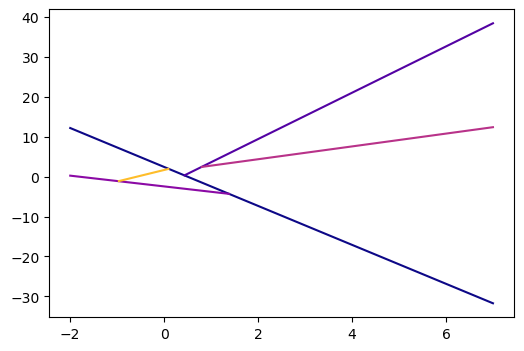

In [ ]:
draw_tree_lines(ws,bs, torch.linspace(-2,7,1000))

# With model training

In [ ]:
set_seed(0)
n_cores = num_cpus()


bs = 32 # batch size
h = 16

Generate swiss-roll dataset

In [ ]:
def swissroll(n=100, std=0.5, n_swirls=0.5):
    t = n_swirls * math.pi * (1 + 2 * torch.rand(n))
    x1 = torch.stack([t * torch.sin(t), t * torch.cos(t)],dim=1)
    x2 = torch.stack([t * torch.sin(t+math.pi), t * torch.cos(t+math.pi)],dim=1)
    return  torch.cat([x1,x2]) + std * torch.randn([2*n,2]), TensorCategory(torch.cat([torch.zeros(n),torch.ones(n)]))

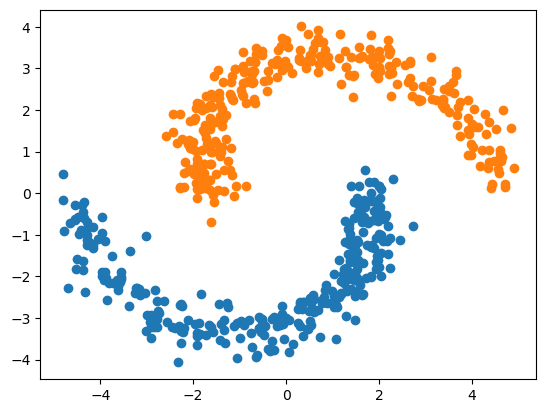

In [ ]:
n = 300
x,y = swissroll(n,std=0.3)
plt.scatter(x[:n,0],x[:n,1]); plt.scatter(x[n:,0],x[n:,1]);

In [ ]:
class SwissrollDS:
    def __init__(self, n=100, std=0.5, n_swirls =0.5): self.x,self.y = swissroll(n,std, n_swirls)
    def __getitem__(self,idx): return self.x[idx], self.y[idx]
    def __len__(self): return len(self.x)
    def show(self, ax = None, figsize=(6,4)):
        if not ax: ax = subplots(figsize=figsize)[1][0]
        n = len(self)//2
        ax.scatter(self.x[:n,0],self.x[:n,1])
        ax.scatter(self.x[n:,0],self.x[n:,1])

In [ ]:
n, std, n_swirls = 400, 0.5, 0.7
train, test = SwissrollDS(n, std, n_swirls), SwissrollDS(n//4, std, n_swirls)
dls = DataLoaders(TfmdDL(train, bs, True, n_cores),
                  TfmdDL(test, bs, False, n_cores))

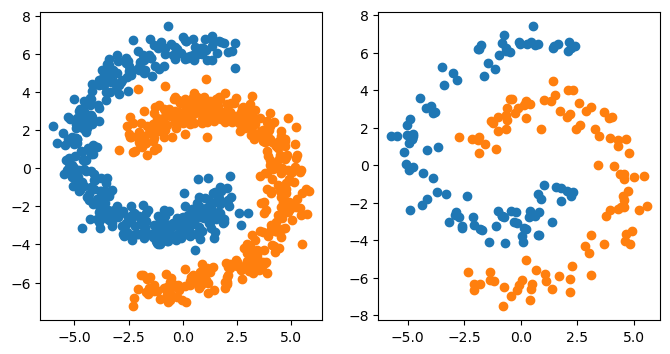

In [ ]:
axes = subplots(ncols=2, figsize=(8,4))[1]
dls.train_ds.show(axes[0]); dls.valid_ds.show(axes[1])

In [ ]:
import FastFF.fff as fff
ls = 8                   # leaf size
d = int(math.log2(h/ls)) # depth so that number of output neurons is h
model_fff = fff.FFF(2, 2, 1, 2)

## Tree before training

In [ ]:
def plot_contour(bounds=(-15.0,15.0), n=1000, model=model_fff, figsize=(6,4), ax=None):
    l,r = bounds
    x = torch.linspace(l,r, n)
    X, Y = torch.meshgrid(x,x,indexing='xy')
    with torch.no_grad(): 
        Z = torch.stack([F.sigmoid(model(b)) for b in progress_bar(torch.stack([X,Y],dim=2))]).squeeze()
    clev = torch.linspace(Z.min(),Z.max(),100)
    if not ax: ax = subplots(figsize=figsize)[1][0]
    ax.contourf(*to_np((X,Y,Z)), clev, cmap=plt.cm.coolwarm)

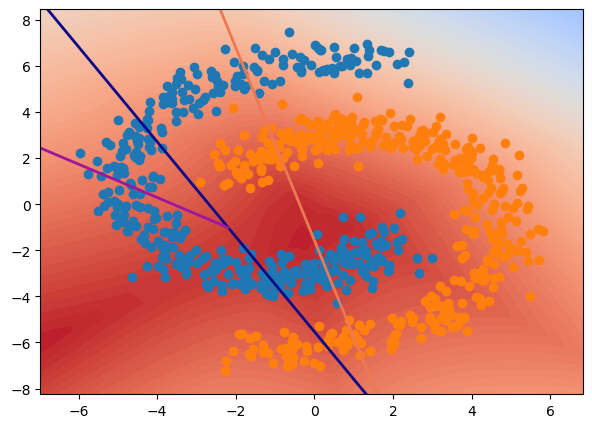

In [ ]:
ax = subplots(figsize=(7,5))[1][0]
plot_contour(ax=ax)
ax.set_ylim(dls.train_ds.x[:,1].min()-1,dls.train_ds.x[:,1].max()+1)
ax.set_xlim(dls.train_ds.x[:,0].min()-1,dls.train_ds.x[:,0].max()+1)
ax.scatter(dls.train_ds.x[:n,0],dls.train_ds.x[:n,1])
ax.scatter(dls.train_ds.x[n:,0],dls.train_ds.x[n:,1])
draw_tree_lines(model_fff.node_weights.detach(), model_fff.node_biases.detach(), torch.linspace(dls.train_ds.x[:,0].min()-5,dls.train_ds.x[:,0].max()+5,3000),
                ax=ax, linewidth=2)

epoch,train_loss,valid_loss,accuracy,time
0,0.469421,0.589577,0.500000,00:00
1,0.465844,0.593030,0.500000,00:00
2,0.460829,0.594900,0.500000,00:00
3,0.449751,0.596039,0.500000,00:00
4,0.430310,0.583916,0.500000,00:00
5,0.401201,0.572810,0.500000,00:00
6,0.367892,0.606084,0.500000,00:00
7,0.330662,0.593714,0.500000,00:00
8,0.293526,0.584718,0.500000,00:00
9,0.260380,0.594541,0.500000,00:00


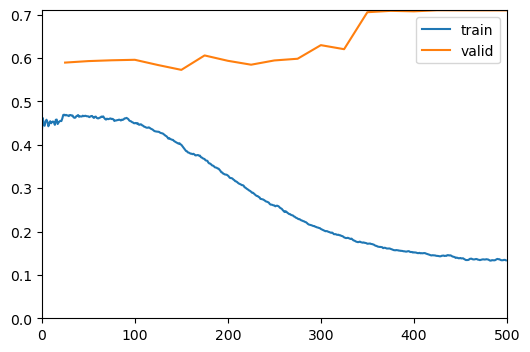

In [ ]:
#|eval: false
cbs = [ShowGraphCallback(), before_batch_cb(lambda s,xb,yb: (xb,(yb[0][:,None],)))]
learn = Learner(dls, model_fff, loss_func=F.binary_cross_entropy_with_logits, metrics=accuracy, opt_func = Adam, cbs=cbs)
learn.fit_one_cycle(20, lr_max=1e-2)

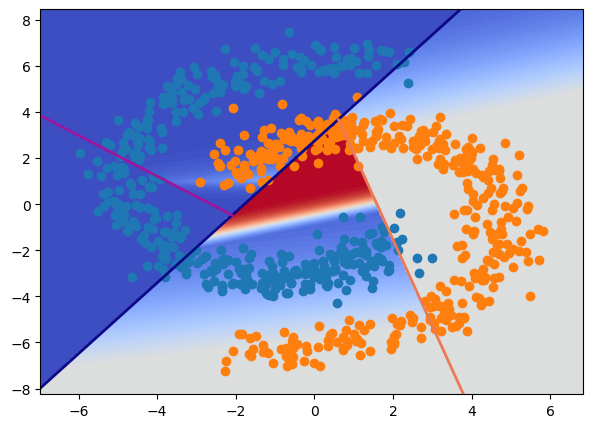

In [ ]:
ax = subplots(figsize=(7,5))[1][0]
plot_contour(n=500, ax=ax)
ax.set_ylim(dls.train_ds.x[:,1].min()-1,dls.train_ds.x[:,1].max()+1)
ax.set_xlim(dls.train_ds.x[:,0].min()-1,dls.train_ds.x[:,0].max()+1)
ax.scatter(dls.train_ds.x[:n,0],dls.train_ds.x[:n,1])
ax.scatter(dls.train_ds.x[n:,0],dls.train_ds.x[n:,1])
draw_tree_lines(model_fff.node_weights.detach(), model_fff.node_biases.detach(), torch.linspace(dls.train_ds.x[:,0].min()-5,dls.train_ds.x[:,0].max()+5,3000),
                ax=ax, linewidth=2)

In [ ]:
import nbdev; nbdev.nbdev_export()